In [2]:
import cv2
import mediapipe as mp
import math
import csv
from datetime import datetime
import os
import winsound  # For sound alert
import matplotlib.pyplot as plt
from collections import deque

In [3]:
def calculate_ear(landmarks, eye_indices, image_w, image_h):
	def get_point(index):
		point = landmarks[index]
		return int(point.x * image_w), int(point.y * image_h)
	
	
	p1, p2 = get_point(eye_indices[1]), get_point(eye_indices[5])
	p3, p4 = get_point(eye_indices[2]), get_point(eye_indices[4])
	p5, p6 = get_point(eye_indices[0]), get_point(eye_indices[3])

	# Calculating the Euclidean distances between pairs of these points. 
	vertical_1 = math.dist(p1, p2)
	vertical_2 = math.dist(p3, p4)
	horizontal = math.dist(p5, p6)

	# Standard Formula to compute EAR.
	ear = (vertical_1 + vertical_2) / (2.0 * horizontal)
	return ear

In [4]:
# EAR parameters and frame count threshold
EAR_THRESHOLD = 0.20 # If the proportion/percentage is less than this value it means eyes are closed
EAR_CONSEC_FRAMES = 50

# Eye landmark indices provided by Mediapipe Library 
LEFT_EYE_INDICES = [33, 160, 158, 133, 153, 144]
RIGHT_EYE_INDICES = [362, 385, 387, 263, 373, 380]

In [5]:
# Initialize mediapipe components
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_face_mesh = mp.solutions.face_mesh

In [6]:
# Drawing specification
my_drawing_specs = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)

In [7]:
# CSV logging setup
log_filename = "drowsiness_log.csv"
if not os.path.exists(log_filename):
	with open(log_filename, 'w', newline='') as f:
		writer = csv.writer(f)
		writer.writerow(["Timestamp", "EAR", "Status"])

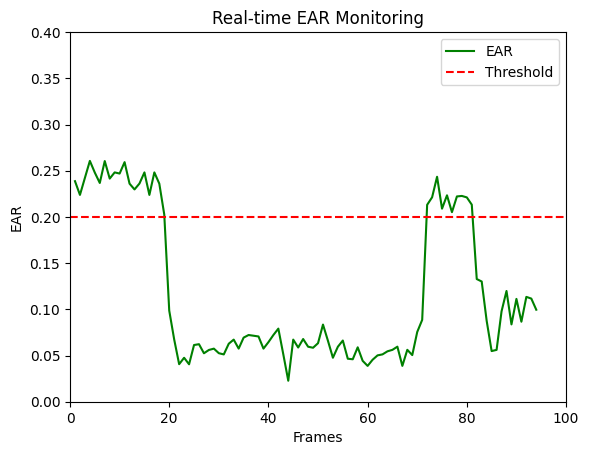

In [10]:
# For Laptop webcam usage use "0" index
cap = cv2.VideoCapture(0)

# Modify the plotting setup
ear_values = deque(maxlen=100)  # Store last 100 EAR values
timestamps = deque(maxlen=100)  # Store last 100 timestamps
plot_frame = 0  # Separate counter for tracking frames in the plot

# Plotting setup
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'g-', label="EAR")
ax.axhline(y=EAR_THRESHOLD, color='r', linestyle='--', label='Threshold')
ax.set_ylim(0, 0.4)
ax.set_title("Real-time EAR Monitoring")
ax.set_xlabel("Frames")
ax.set_ylabel("EAR")
ax.legend()

def update_plot(new_ear):
	global plot_frame
	plot_frame += 1  # Increment frame counter
	ear_values.append(new_ear)
	timestamps.append(plot_frame)  # Use plot_frame as x-value
	
	line.set_xdata(timestamps)
	line.set_ydata(ear_values)
	
	# Adjust x-axis to show the latest 100 frames
	if plot_frame > 100:
		ax.set_xlim(plot_frame - 99, plot_frame)
	else:
		ax.set_xlim(0, 100)
	
	ax.relim()
	ax.autoscale_view(scaley=True)  # Autoscale only y-axis
	fig.canvas.draw()
	fig.canvas.flush_events()

with mp_face_mesh.FaceMesh(
	max_num_faces=1,
	refine_landmarks=True,
	min_detection_confidence=0.5,
	min_tracking_confidence=0.5
) as face_mesh:

	while cap.isOpened():
		# This will read the image from camera and stores it in image variable
		success, image = cap.read()
		if not success:
			print("Ignoring empty camera frame.")
			continue

		# Flip and convert to RGB
		image = cv2.flip(image, 1)
		rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

		# Process the image
		results = face_mesh.process(rgb_image)

		# Draw landmarks only if it's detected
		if results.multi_face_landmarks:
			for face_landmarks in results.multi_face_landmarks:

				# EAR Calculation
				landmarks = face_landmarks.landmark
				image_h, image_w, _ = image.shape

				left_ear = calculate_ear(landmarks, LEFT_EYE_INDICES, image_w, image_h)
				right_ear = calculate_ear(landmarks, RIGHT_EYE_INDICES, image_w, image_h)
				avg_ear = (left_ear + right_ear) / 2.0

				# Plotting EAR
				update_plot(avg_ear)
				
				# Display EAR
				cv2.putText(image, f'EAR: {avg_ear:.2f}', (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

				# Drowsiness detection
				if avg_ear < EAR_THRESHOLD:
					frame_counter += 1
					if frame_counter >= EAR_CONSEC_FRAMES:
						status = "Drowsy"
						winsound.Beep(1000, 500)

						#  Saving image
						filename = f'drowsy_{datetime.now().strftime("%Y%m%d_%H%M%S")}.jpg'
						cv2.imwrite(filename, image)

						# Saving logs
						with open(log_filename, 'a', newline='') as f:
								writer = csv.writer(f)
								writer.writerow([datetime.now(), round(avg_ear, 2), status])

						# Alert text
						# image-name, Message, Coordinates, Fonts, Font-Size, Color, Thickness
						cv2.putText(image, "DROWSINESS ALERT!", (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

				else:
					frame_counter = 0
					status = "AWAKE"

				# Tesselation
				# It is a pre-defined set of connections that represent the structure of the face as a mesh of triangles (tesselation). This tells the draw_landmarks function how to connect the individual landmarks to form this mesh.

				mp_drawing.draw_landmarks(
					image=image,
					landmark_list=face_landmarks,
					connections=mp_face_mesh.FACEMESH_TESSELATION,
					landmark_drawing_spec=None,
					connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
				)
				
				# Contours
				mp_drawing.draw_landmarks(
					image=image,
					landmark_list=face_landmarks,
					connections=mp_face_mesh.FACEMESH_CONTOURS,
					landmark_drawing_spec=None,
					connection_drawing_spec = my_drawing_specs

				)

				# Draw left eye points
				for index in LEFT_EYE_INDICES:
					point = face_landmarks.landmark[index]
					x = int(point.x * image.shape[1])
					y = int(point.y * image.shape[0])
					# image, center_coordinates, radius, color, thickness
					cv2.circle(image, (x, y), 2, (0, 255, 255), -1)

				# Draw right eye points
				for index in RIGHT_EYE_INDICES:
					point = face_landmarks.landmark[index]
					x = int(point.x * image.shape[1])
					y = int(point.y * image.shape[0])
					# image, center_coordinates, radius, color, thickness
					cv2.circle(image, (x, y), 2, (0, 255, 255), -1)

		# Show the output
		cv2.imshow("Dectecting Drowsiness", image)

		# Press 'Esc' to exit
		# 1 in waitkey helps to render video while zero is useful for image
		if cv2.waitKey(1) & 0xFF == 27:
			break

# Releases the video capture device, freeing up the camera for other applications.
cap.release()
# Closes all the OpenCV windows that were created.
cv2.destroyAllWindows()